In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Multinomial naive bayes

In [3]:
df = pd.read_csv("data/prepared_data.csv")

In [4]:
df.shape

(255082, 10)

In [5]:
df['DocumentType'].unique()

array(['Review', 'Tweet'], dtype=object)

In [6]:
df.head()

,DocumentID,Text,Label,LabelType,LabelName,DocumentType,LengthCharacters,HasEmoji,cleaned_text,LabelMapped
0,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",1,StarRating,1 Star,Review,612,0,arrived broken manufacturer defect two of the legs of the base were not completely formed so there was no way to insert the casters i unpackaged the entire chair and hardware before noticing this so ill spend twice the amount of time boxing up the whole useless thing and send it back with a star review of part of a chair i never got to sit in i will go so far as to include a picture of what their injection molding and quality assurance process missed though i will be hesitant to buy again it makes me wonder if there arent missing structures and supports that dont impede the assembly process,-1
1,2,the cabinet dot were all detached from backing... got me,1,StarRating,1 Star,Review,56,0,the cabinet dot were all detached from backing got me,-1
2,3,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed.,1,StarRating,1 Star,Review,206,0,i received my first order of this product and it was broke so i ordered it again the second one was broke in more places than the first i cant blame the shipping process as its shrink wrapped and boxed,-1
3,4,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!",1,StarRating,1 Star,Review,145,0,this product is a piece of shit do not buy doesnt work and then i try to call for customer support it wont take my number fucking rip off,-1
4,5,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without),1,StarRating,1 Star,Review,91,0,went through in one day doesnt fit correct and couldnt get bubbles out better without,-1


## 1. First attempt without any optimisations

### 1.1 Prepare data

In [7]:
X = df['cleaned_text']
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.2 Vectorize text

In [8]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

vocabulary = vectorizer.vocabulary_
print(vocabulary)

{'dress': 23030, 'fit': 28309, 'perfectly': 71383, 'in': 49746, 'here': 35467, 'worked': 102328, 'great': 32960, 'for': 29255, 'couple': 17356, 'months': 63510, 'then': 92499, 'stopped': 88746, 'working': 102357, 'while': 101226, 'another': 3204, 'brand': 9683, 'has': 34687, 'continued': 16657, 'to': 94072, 'work': 102301, 'right': 79275, 'alongside': 2223, 'this': 93039, 'one': 68485, 'only': 68646, 'purchased': 75375, 'different': 21192, 'because': 6845, 'it': 51490, 'turned': 96026, 'out': 69367, 'needed': 65452, 'two': 96301, 'and': 2855, 'was': 100040, 'of': 67878, 'stock': 88653, 'at': 4655, 'the': 92195, 'time': 93690, 'now': 67180, 'both': 9319, 'have': 34796, 'each': 23784, 'other': 69256, 'til': 93648, 'crapped': 17626, 'canut': 11935, 'watch': 100134, 'rafaus': 76156, 'iull': 51829, 'be': 6674, 'back': 5494, 'video': 99038, 'enduc': 25064, 'itus': 51797, 'too': 94537, 'heartbreaking': 35089, 'plus': 72886, 'just': 53732, 'reminded': 78022, 'me': 61052, 'he': 34941, 'up': 977

In [9]:
# If we want to see the vectorization
X_array = X_train_tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()
print("Feature Names (Vocabulary):")
print(feature_names)
print("\nTF-IDF Matrix:")
print(X_array)

Feature Names (Vocabulary):
['aa' 'aaa' 'aaaa' ... 'zzzzzzzz' 'zzzzzzzzzz' 'ítem']

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 1.3 Train a model 

In [10]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

### 1.4 Evaluate the model

In [11]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.66      0.80      0.72     17993
           0       0.59      0.20      0.29     12600
           1       0.67      0.83      0.74     20424

    accuracy                           0.66     51017
   macro avg       0.64      0.61      0.59     51017
weighted avg       0.65      0.66      0.62     51017



           Predicted -1  Predicted 0  Predicted 1
Actual -1         14370          823         2800
Actual 0           4731         2482         5387
Actual 1           2637          931        16856


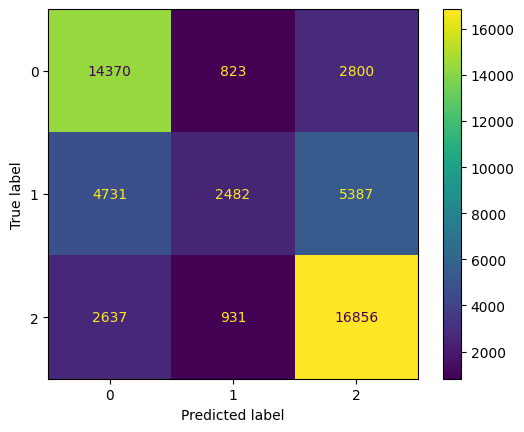

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [13]:
import pickle
filename = 'naive_bayes.model'
deployment = {"vectorizer": TfidfVectorizer ( vocabulary = vocabulary ), 
              "classifier": model }

# write deployment to file
with open(filename , 'wb') as file:
    pickle.dump( deployment , file)

# test if we can load the model and make a prediction (will be done by our API)
with open(filename , 'rb') as file:
    model = pickle.load(file)

text = ['This model works!', 'This is a very bad model .', 'The weather was okay.']
X_pred = model['vectorizer'].fit_transform(text)
y_pred = model['classifier'].predict( X_pred )
print ( y_pred )

[ 1 -1  0]


### 2.1 Create pipeline for hyperparameters search

In [14]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

### 2.2 Search for most optimal hyperparams

In [15]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [16]:
# Print best parameters
print(grid_search.best_params_)

{'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}


### 2.3 Predict the results using model with most optimal hyperparams

In [17]:
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'], 
                              ngram_range=best_params['tfidf__ngram_range'])),
    ('nb', MultinomialNB(alpha=best_params['nb__alpha']))
])

# Fit the final model with the best parameters on the entire training data
final_pipeline.fit(X_train, y_train)

# Now you can use final_pipeline to predict new data
y_pred = final_pipeline.predict(X_test)

### 2.4 Evaluate the model

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.68      0.83      0.75     17993
           0       0.56      0.28      0.37     12600
           1       0.74      0.82      0.77     20424

    accuracy                           0.69     51017
   macro avg       0.66      0.64      0.63     51017
weighted avg       0.67      0.69      0.66     51017



           Predicted -1  Predicted 0  Predicted 1
Actual -1         14944         1249         1800
Actual 0           4965         3519         4116
Actual 1           2207         1562        16655


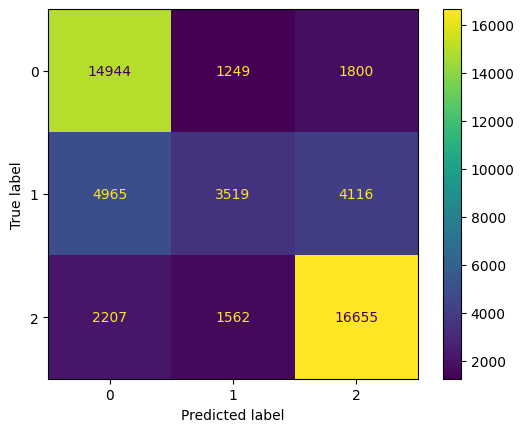

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()